In [1]:
import pandas as pd
import numpy as np
import torch
from pytorch_pretrained_bert import BertForSequenceClassification

from transformers import BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split, RandomSampler

import matplotlib.pyplot as plt

import random
import pickle
import time
from datetime import datetime

import os
import gdown

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Users/Gerardo/.virtualenvs/neuro_match/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_path  = '../data/56min_2023_07_info_final_model' #path to the model that we are going to load
data_path = '../data/56min_2023_07_info_final' #path to the info dictionary containing the hyperparameters for the dataset

In [4]:
seed = 31

## Set the random seeds for Python and Torch
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

def seed_worker(worker_id): #function to initalize the seeds for the workers of DataLoader
    worker_seed = torch.initial_seed() %2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_seed = torch.Generator()
g_seed.manual_seed(seed)

In [5]:
def custom_train_test_split(df,features = 'input_ids',target = 'label',attention = 'attention_mask' ,test_size = 0.2,val_size = 0.2,gen_seed= g_seed):
    """Return two dataset objects of training and testing samples respectively

    Args:
        df (pandas.DataFrame): DataFrame containing all the relevant columns 
        features (str, optional): DataFrame column correspondign to the feature components. Defaults to 'input_ids'.
        target (str, optional): DataFrame column corresponding to the label/target . Defaults to 'label'.
        attention (str, optional): DataFrame column corresponding to the attention tokens. Defaults to 'attention_mask'.
        test_size (float, optional): Percent size assigned to testing. Defaults to 0.2.
        val_size (float, optional): Percent size assigne to validation. Defaults to 0.2.
        gen_seed(torch.Generator, optional): Generator for seeding the random split. Defaults to g_seed defined at the start.

    Returns:
        tuple: Training,testing, and validation datasets objects respectively
    """
    
    
    #Turn DataFrame into tensor objects and then into a dataset
    X_label = torch.cat(df[features].to_list(),dim = 0) #tokenized data
    X_attention = torch.cat(df[attention].to_list(),dim = 0) #whether its a word or padding
    y = torch.tensor(df[target].to_list())
    dataset = TensorDataset(X_label,X_attention,y)
    
    #Split into training and testing datasets
    num_samps = df.shape[0]
    num_test = int(num_samps*test_size)
    num_val = int(num_samps*val_size)
    num_train = num_samps - num_test - num_val
    
    train_data, test_data, val_data = random_split(dataset,[num_train,num_test,num_val],generator = gen_seed)
    
    return train_data,test_data,val_data

def load_checkpoint_model(load_path = '10min_2023_07_checkpoint'):
  """Load model, optimizer, and system properties.

  Args:
      load_path (str) : path to load from.

  Returns:
      tuple : BERT model,torch.optim, curr_epoch, train_losses,val_losses, accuracies
  """ 
  with open(f'data/{load_path}','rb') as fid:
    checkpoint_dict = pickle.load(fid) 
      
  empty_model = torch.load(f'data/{load_path}_model')
  empty_optim = torch.load(f'data/{load_path}_optim')
      
  return empty_model,empty_optim


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: Running on cpu ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [7]:
if not os.path.isfile('../data/modeling_data.zip'):
    id = '1p3wPDlGq7fsIjiEV2hce90N-OI3YCOdw'
    output = "../data/modeling_data.zip"
    gdown.download(id=id, output=output, quiet=False)
    
df = pd.read_pickle('../data/modeling_data.zip')
df.label = df.label.astype('uint8')

In [9]:

model = torch.load(f'{model_path}')
with open(f'{data_path}','rb') as f:
    info = pickle.load(f)

In [10]:
train_dataset, test_dataset, validation_dataset = custom_train_test_split(df,test_size = info['test_data_size'], val_size = info['val_data_size'])
test_loader = DataLoader(test_dataset,batch_size = info['batch_size'] , shuffle = False, num_workers = 0, worker_init_fn = seed_worker, generator = g_seed)

In [11]:
device = set_device()
model.eval()
all_labels = np.array([0])
all_preds = np.array([0])
for test_iter,batch in enumerate(test_loader):

    feature = batch[0].to(device)
    attention = batch[1].to(device)
    labels = batch[2]
    
    with torch.no_grad():
        logits = model(feature,token_type_ids = None,attention_mask =  attention).detach().cpu().numpy()
    y_preds = np.argmax(logits,axis = 1)
    all_preds = np.append(all_preds,y_preds)
    all_labels = np.append(all_labels,labels)

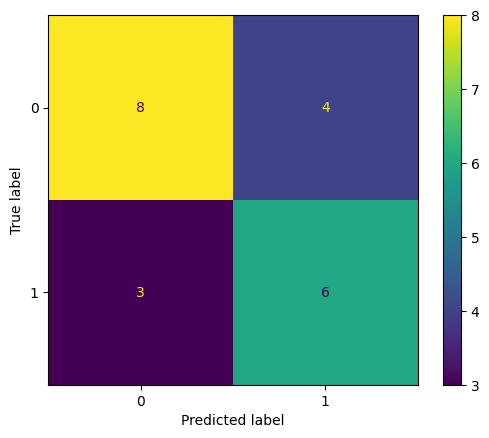

In [12]:
y_preds = np.round(np.array(all_preds))
y_true = np.array(all_labels)

cm = confusion_matrix(y_true,y_preds)
ConfusionMatrixDisplay(cm).plot()

plt.savefig('../data/confusion_matrix.png')